In [230]:
import torch
import math
import random
import numpy as np
import pandas as pd
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from datetime import datetime

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class NeuralNetwork(nn.Module):
    def __init__(self, list_layer):
        super(NeuralNetwork, self).__init__()
        self.layer_list = list_layer
        self.layer_num = 0
        self.activation_num = 0
        self.convolution_num = 0
        self.pool_num = 0

        self.sequential = self.layer_stack(self.layer_list)
        print(self.sequential)

    def forward(self, x):
        i = self.sequential(x)
        return i

    def layer_stack(self, x):
        print(x)
        seq = nn.Sequential()
        for i in x:
            if i[0] == 'ln':
                self.layer_num += 1
                seq.add_module('layer_' + str(self.layer_num) + '_Linear', nn.Linear(i[1], i[2]))
            elif i[0] == 'relu':
                self.activation_num += 1
                seq.add_module('activation_' + str(self.activation_num) + '_Relu', nn.ReLU())
            elif i[0] == 'sigmoid':
                self.activation_num += 1
                seq.add_module('activation_' + str(self.activation_num) + '_Sigmoid', nn.Sigmoid())

        return seq


In [231]:
load_data = pd.read_csv('/content/load_data')
weather_data = pd.read_csv('/content/weather_data')
dataset = []
start_date = datetime.strptime(weather_data.columns[1],'%Y/%m/%d')
for i in weather_data.columns:
  if i=='Unnamed: 0':
    continue
  day_week = datetime.strptime(i, "%Y/%m/%d")
  for f in range(0,24):
    dataset.append(i.split('/')+[str((day_week-start_date).days),str(day_week.weekday())]+weather_data[i][f].split('/'))
print(dataset)
index=0
for i in load_data.columns:
  if i=='Unnamed: 0':
    continue
  for f in range(0,24):
    dataset[index]+=[load_data[i][f]]
    index+=1
print(dataset)

[['2022', '07', '01', '0', '4', '0', '25.6', '2.2', '180', '99', 'nan', 'nan', '3.0', '25.0'], ['2022', '07', '01', '0', '4', '1', '25.1', '1.4', '200', '99', 'nan', 'nan', '2.0', '24.8'], ['2022', '07', '01', '0', '4', '2', '25.0', '1.8', '180', '99', 'nan', 'nan', '4.0', '24.4'], ['2022', '07', '01', '0', '4', '3', '24.9', '1.6', '200', '99', 'nan', 'nan', '2.0', '24.2'], ['2022', '07', '01', '0', '4', '4', '24.5', '0.4', '0', '99', 'nan', 'nan', '3.0', '24.0'], ['2022', '07', '01', '0', '4', '5', '24.4', '1.0', '50', '99', 'nan', 'nan', '3.0', '24.0'], ['2022', '07', '01', '0', '4', '6', '24.0', '0.9', '90', '99', '0.1', '0.1', '2.0', '24.0'], ['2022', '07', '01', '0', '4', '7', '25.1', '0.9', '70', '99', '1.0', '0.59', '2.0', '24.5'], ['2022', '07', '01', '0', '4', '8', '27.3', '2.5', '200', '88', '1.0', '1.29', '2.0', '27.4'], ['2022', '07', '01', '0', '4', '9', '28.4', '3.3', '180', '83', '1.0', '1.96', '1.0', '32.0'], ['2022', '07', '01', '0', '4', '10', '29.8', '1.9', '160', '7

In [232]:
npdataset = np.array(dataset)
npdataset[npdataset=='nan']='0'
npdataset = npdataset.astype(float)
print(npdataset[0])

[2.0220e+03 7.0000e+00 1.0000e+00 0.0000e+00 4.0000e+00 0.0000e+00
 2.5600e+01 2.2000e+00 1.8000e+02 9.9000e+01 0.0000e+00 0.0000e+00
 3.0000e+00 2.5000e+01 6.5956e+03]


In [233]:
select_col = [1,2,4,5,6,7,13,14]
select_data = npdataset[:,select_col]
min_vals = np.min(select_data, axis=0)
max_vals = np.max(select_data, axis=0)
scaled_data = (select_data - min_vals) / (max_vals - min_vals)
#scaled_data[:,[7]] = npdataset[:,[14]]
print(scaled_data[0])

[0.         0.         0.66666667 0.         0.4702381  0.275
 0.2        0.28590208]


In [234]:
def split_data(dset,ratio):
  tx=[]
  ty=[]
  vx=[]
  vy=[]
  for i in dset:
    if(random.uniform(0, 1)<ratio):
      tx.append(i[0:7])
      ty.append(i[7])
    else:
      vx.append(i[0:7])
      vy.append(i[7])
  return tx,ty,vx,vy

set_ratio = 0.75

train_X,train_Y,val_X,val_Y = split_data(scaled_data,set_ratio)
train_X=torch.Tensor(train_X).float().to(device)
train_Y=torch.Tensor(train_Y).float().to(device)
val_X=torch.Tensor(val_X).float().to(device)
val_Y=torch.Tensor(val_Y).float().to(device)
print(train_X[0])
print(train_Y[0])

tensor([0.0000, 0.0000, 0.6667, 0.0000, 0.4702, 0.2750, 0.2000])
tensor(0.2859)


In [235]:
batch_size = 4
train_loader = DataLoader(TensorDataset(train_X, train_Y), batch_size=batch_size, shuffle=False)
val_loader = DataLoader(TensorDataset(val_X, val_Y), batch_size=batch_size, shuffle=False)

In [236]:
list_layer = [['ln', 7, 28],['relu'],['ln',28, 28],['relu'],['ln', 28, 28],['relu'],['ln', 28, 28],['relu'],['ln', 28, 28],['relu'],['ln', 28, 1]]

model = NeuralNetwork(list_layer).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

[['ln', 7, 28], ['relu'], ['ln', 28, 28], ['relu'], ['ln', 28, 28], ['relu'], ['ln', 28, 28], ['relu'], ['ln', 28, 28], ['relu'], ['ln', 28, 1]]
Sequential(
  (layer_1_Linear): Linear(in_features=7, out_features=28, bias=True)
  (activation_1_Relu): ReLU()
  (layer_2_Linear): Linear(in_features=28, out_features=28, bias=True)
  (activation_2_Relu): ReLU()
  (layer_3_Linear): Linear(in_features=28, out_features=28, bias=True)
  (activation_3_Relu): ReLU()
  (layer_4_Linear): Linear(in_features=28, out_features=28, bias=True)
  (activation_4_Relu): ReLU()
  (layer_5_Linear): Linear(in_features=28, out_features=28, bias=True)
  (activation_5_Relu): ReLU()
  (layer_6_Linear): Linear(in_features=28, out_features=1, bias=True)
)


In [237]:
num_epochs = 1000

train_loss=[]
val_loss=[]

vcrit = nn.MSELoss()

for epoch in range(num_epochs):
    running_loss = 0.0
    model.train()
    for batch_X, batch_Y in train_loader:
      optimizer.zero_grad()
      outputs = model(batch_X)
      loss = criterion(outputs, batch_Y)
      #rloss = torch.sqrt(loss)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()

    vrunning_loss = 0.0
    model.eval()
    with torch.no_grad():
        for vbatch_X, vbatch_Y in val_loader:
          voutputs = model(vbatch_X)
          vloss = vcrit(voutputs,vbatch_Y)
          #rvloss = torch.sqrt(vloss)
          vrunning_loss+=vloss.item()

    train_loss.append(running_loss)
    val_loss.append(vrunning_loss)

    if epoch%100==0:
        print('Epoch: %d | Loss: %.4f' % (epoch + 1, running_loss))

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, targe

Epoch: 1 | Loss: 21.0575
Epoch: 101 | Loss: 8.1361
Epoch: 201 | Loss: 5.2097
Epoch: 301 | Loss: 4.8519
Epoch: 401 | Loss: 4.5785
Epoch: 501 | Loss: 4.3875
Epoch: 601 | Loss: 4.3346
Epoch: 701 | Loss: 4.3249
Epoch: 801 | Loss: 4.2586
Epoch: 901 | Loss: 4.2235


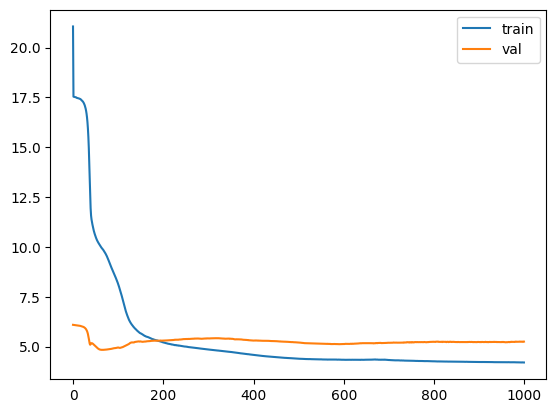

In [238]:
plt.plot(train_loss,label='train')
plt.plot(val_loss,label='val')
plt.legend()
plt.show()

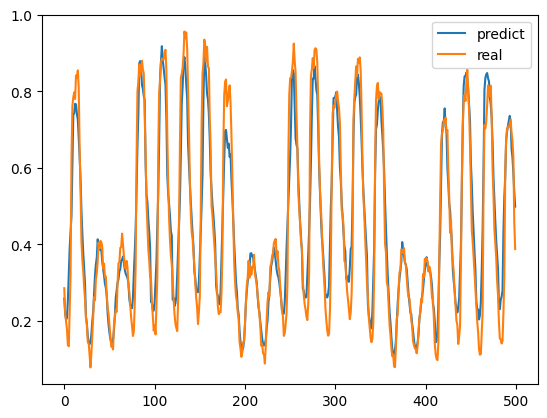

In [239]:
model.eval()
testX = scaled_data[0:500,0:7]
testY = scaled_data[0:500,[7]]
predictY = model(torch.Tensor(testX))

plt.title('부하량')
plt.plot(predictY.detach().numpy(),label='predict')
plt.plot(testY,label='real')
plt.legend()
plt.show()

In [240]:
torch.save(model,'/content/load_fullmodel.pt')
torch.save(model.state_dict(),'/content/load_statedict.pt')

[['ln', 7, 28], ['relu'], ['ln', 28, 28], ['relu'], ['ln', 28, 28], ['relu'], ['ln', 28, 28], ['relu'], ['ln', 28, 28], ['relu'], ['ln', 28, 1]]
Sequential(
  (layer_1_Linear): Linear(in_features=7, out_features=28, bias=True)
  (activation_1_Relu): ReLU()
  (layer_2_Linear): Linear(in_features=28, out_features=28, bias=True)
  (activation_2_Relu): ReLU()
  (layer_3_Linear): Linear(in_features=28, out_features=28, bias=True)
  (activation_3_Relu): ReLU()
  (layer_4_Linear): Linear(in_features=28, out_features=28, bias=True)
  (activation_4_Relu): ReLU()
  (layer_5_Linear): Linear(in_features=28, out_features=28, bias=True)
  (activation_5_Relu): ReLU()
  (layer_6_Linear): Linear(in_features=28, out_features=1, bias=True)
)


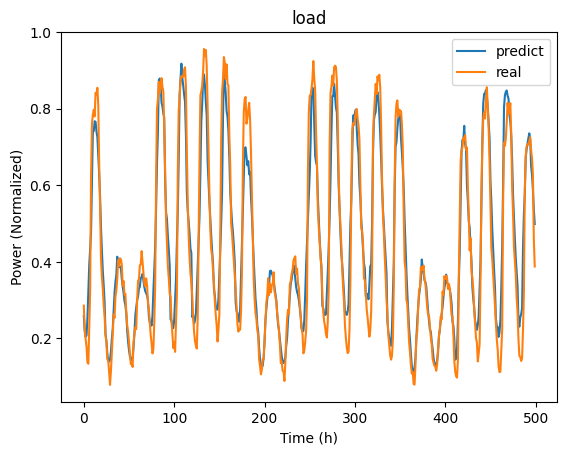

In [247]:
test_model = NeuralNetwork(list_layer).to(device)
test_model.load_state_dict(torch.load('/content/load_statedict.pt'))
test_model.eval()

ptestX = scaled_data[0:500,0:7]
ptestY = scaled_data[0:500,[7]]
py = test_model(torch.Tensor(ptestX))

plt.title('load')
plt.plot(py.detach().numpy(),label='predict')
plt.plot(ptestY,label='real')
plt.xlabel('Time (h)')
plt.ylabel('Power (Normalized)')
plt.legend()
plt.show()